## Implementação do protocolo "Quantum Teleportation" (C. Bennet et al)

Alunos:

- João V. G. Woitschach
- Jerônimo Augusto Soares


### Imports das libs

In [1]:
import qiskit
import os
import numpy as np
from dotenv import load_dotenv
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, state_fidelity
import cmath


load_dotenv('.env')


True

### Parte 1: Protocolo incompleto - comunicação mais rápida que a luz?

In [ ]:
# 2011401
# 1921209

n_5 = 2
n_6 = 0
n_7 = 9

# N5 = int(os.getenv('n_5'))
# N6 = int(os.getenv('n_6'))
# N7 = int(os.getenv('n_7'))

print("Qiskit version:", qiskit.__version__)
N5 = n_5
N6 = n_6
N7 = n_7
print(N5,N6,N7)

Qiskit version: 2.1.1
2 0 9


In [3]:
# --- Calcular os coeficientes do estado normalizado ---
amplitude_0 = N5 + 1
amplitude_1_base = N6 + 1
phase_exponent = 2 * (N7 + 1) * np.pi / 11

# Coeficientes sem normalização
coeff_0_unnorm = amplitude_0
coeff_1_unnorm = amplitude_1_base * np.exp(1j * phase_exponent)

# Normalização
norm_factor = np.sqrt(abs(coeff_0_unnorm)**2 + abs(coeff_1_unnorm)**2)

# Coeficientes normalizados
coeff_0 = coeff_0_unnorm / norm_factor
coeff_1 = coeff_1_unnorm / norm_factor

# O vetor de estado que será passado para initialize()
state_vector = [coeff_0, coeff_1]

# Calcula os ângulos theta e phi
theta = 2 * np.arccos(abs(coeff_0))
phi = cmath.phase(coeff_1)


print(f"Estado a ser preparado (normalizado):")
print(f"|phi_A> = {coeff_0:.5f} |0> + ({coeff_1.real:.5f} {coeff_1.imag:+.5f}j) |1>")
print("-" * 30)


print("Probabilidade de medir |0>: %.2f"%abs(coeff_0)**2)
print("Probabilidade de medir |1>: %.2f"%abs(coeff_1)**2)

Estado a ser preparado (normalizado):
|phi_A> = 0.94868 |0> + (0.26603 -0.17097j) |1>
------------------------------
Probabilidade de medir |0>: 0.90
Probabilidade de medir |1>: 0.10


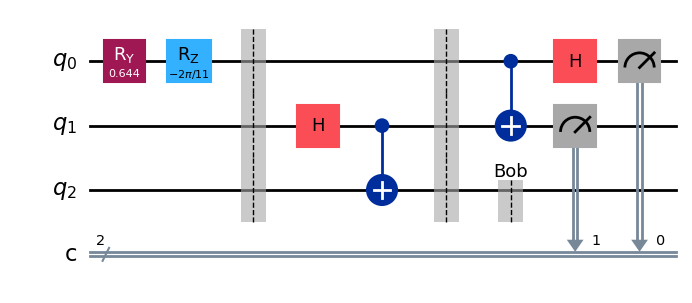

In [4]:
# Cria o circuito com 3 qubits (q0, q1, q2) e 2 bits clássicos
qc = QuantumCircuit(3, 2)

# 1. Prepara o qubit de Alice (q0) no estado |φA⟩

qc.ry(theta, 0) # Aplica a rotação Y
qc.rz(phi, 0)   # Aplica a rotação Z

# qc.initialize(state_vector, 0)
qc.barrier() # Barreira para melhor visualização

# 2. Prepara o estado de Bell |Φ+⟩ entre q1 e q2
qc.h(1)      # Aplica Hadamard em q1
qc.cx(1, 2)  # Aplica CNOT com q1 como controle e q2 como alvo
qc.barrier()

qc.cx(0,1)  # Aplica CNOT com q0 como controle e q1 como alvo
qc.h(0)

qc.measure([0,1], [0,1])  # Mede q0 e q1, armazenando os resultados nos bits clássicos correspondentes
qc.save_density_matrix([2], label='Bob')  # Salva a matriz densidade do qubit de Bob (q2)


# Desenha o qco
simulator = AerSimulator()

job = simulator.run(qc, shots=10000) # shots = número de vezes para rodar o circuito
result = job.result()

counts = result.get_counts(qc)
saved_data = result.data(0)
density_matrix_q2 = saved_data['Bob']


qc.draw("mpl")


In [5]:
print("\nMatriz de densidade do qubit 2:")
density_matrix_q2


Matriz de densidade do qubit 2:
DensityMatrix([[0.50248   +0.j        , 0.00095903+0.00142729j],
               [0.00095903-0.00142729j, 0.49752   +0.j        ]],
              dims=(2,))


- Bob não possui informação sobre qual estado de Bell é sem saber a medida de Alice!
- Só é possível Bob extrair informação do resultado se ele souber o estado de Bell medido por Alice, pois a matriz de densidade representa (aproximadamente) 1/2 da Identidade, no qual representa o estado de incerteza máxima

## Parte 2: Protocolo completo - implementando as operações unitárias e comunicação clássica

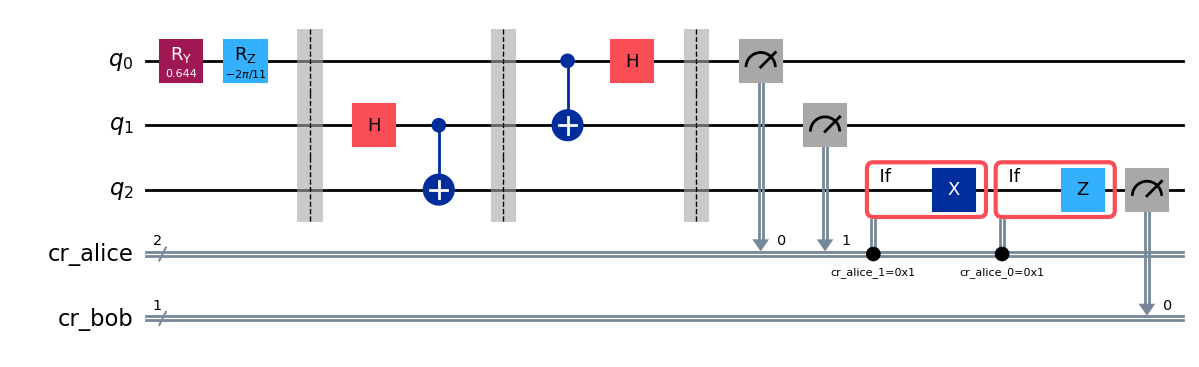

In [6]:
# Cria o circuito com 3 qubits (q0, q1, q2) e 3 bits clássicos

q = qiskit.QuantumRegister(3, 'q')
cr_alice = qiskit.ClassicalRegister(2, 'cr_alice') 
cr_bob = qiskit.ClassicalRegister(1, 'cr_bob') 

qc = QuantumCircuit(q, cr_alice, cr_bob)

# 1. Prepara o qubit de Alice (q0) no estado |φA⟩
qc.ry(theta, 0) # Aplica a rotação Y
qc.rz(phi, 0)   # Aplica a rotação Z
qc.barrier() # Barreira para melhor visualização

# 2. Prepara o estado de Bell |Φ+⟩ entre q1 e q2
qc.h(1)      
qc.cx(1, 2)  
qc.barrier()

# 3. Realiza medida de Bell entre q0 e q1
qc.cx(0,1)  
qc.h(0)
qc.barrier()


qc.measure(q[0], cr_alice[0])
qc.measure(q[1], cr_alice[1])


# 4. Bob aplica operações unitárias baseadas na medida de Alice

#Se o primeiro bit da Alice for 1: Bob aplica uma porta X em q2
with qc.if_test((cr_alice[1], True)):
    qc.x(2)

#Se o segundo bit da Alice for 1: Bob aplica uma porta Z em q2​.
with qc.if_test((cr_alice[0], True)):
    qc.z(2)


qc.measure(q[2], cr_bob[0])


qc.draw("mpl")


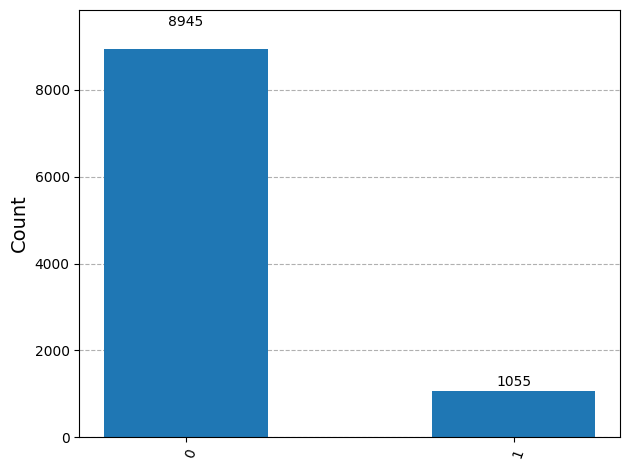

In [7]:
sampler = SamplerV2()
job = sampler.run([qc], shots=10000)  # shots = número de vezes para rodar o circuito

q2_sample = job.result()[0].data.cr_bob.to_bool_array()

plot_histogram({"0":sum(~q2_sample), "1": sum(q2_sample)})

Como foi descoberto na questão 1 que as probabilidades esperadas para o estado de Alice eram 90% de $|0\rangle$, e 10% de $|1\rangle$, no gráfico acima é possível perceber que experimentalmente o resultado obtido foi aproximadamente igual ao estado esperado.

Nesse sentido, apenas após a informação que Alice forneceu a Bob (como uma espécie de "chave") sobre qual operador ele deveria aplicar em q2 antes de medir a informação poderia ser retirada de fato por Bob, havendo assim o "teletransporte" de informação quântica. Porém como Bob ainda depende de um meio de comunicação padrão para se comunicar com Alice, também não há transmissão de informação mais rápida do que a luz.

Por fim, também podemos concluir que não houve violação do Teorema da Não-clonagem pois não foi duplicado o estado, porém a informação que ele carregava foi "transferida para outro". Ou seja, como o estado original carregava a informação de que:

- há 90% de chance de ser $|0\rangle$
- há 10% de chance de ser $|1\rangle$

E ao medirmos 10.000 vezes produzimos estocasticamente resultados aproximadamente iguais, portanto podemos afirmar que as probabilidades do estado foram transferidas para um novo estado, depois que Alice mediu e, como no momento da medida de Alice seu estado original é perdido (não há coexistência entre o estado de saída de Bob e o de entrada de Alice), portanto não houve clonagem.